# AutoML Image Classification: Added Noise (Digits)

![](imgs/gaussian_noise.png)

In [1]:
import random as rn
from abc import ABC, abstractmethod

import autokeras as ak
import h2o
import matplotlib.pyplot as plt
import numpy as np
from h2o.automl import H2OAutoML
from keras.datasets import fashion_mnist
from numpy.random import RandomState
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier

from dpemu import runner
from dpemu.filters.common import GaussianNoise, Clip
from dpemu.filters.image import RotationPIL
from dpemu.nodes import Array
from dpemu.nodes.series import Series
from dpemu.plotting_utils import visualize_scores, print_results_by_model
from dpemu.utils import generate_tmpdir

/wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/wrk/users/thalvari/dpEmu-AutoML/venv

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


Using TensorFlow backend.


In [2]:
def get_data():
    random_state = RandomState(42)
    x, y = load_digits(return_X_y=True)
    return train_test_split(x, y, test_size=.2, random_state=random_state)
    # (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    # s = x_train.shape[1]
    # x_train = x_train.reshape((len(x_train), s ** 2))
    # x_test = x_test.reshape((len(x_test), s ** 2))
    # return x_train, x_test, y_train, y_test

In [3]:
def get_err_root_node():
    err_img_node = Array(reshape=(8, 8))
    # err_img_node = Array(reshape=(28, 28))

    # err_root_node = Series(err_img_node)
    # err_img_node.addfilter(RotationPIL("max_angle"))
    # return err_root_node
    err_root_node = Series(err_img_node)
    err_img_node.addfilter(GaussianNoise("mean", "std"))
    err_img_node.addfilter(Clip("min_val", "max_val"))
    return err_root_node

In [4]:
def get_err_params_list(data):
    # angle_steps = np.linspace(0, 90, num=6)
    # err_params_list = [{"max_angle": a} for a in angle_steps]
    # return err_params_list
    min_val = np.amin(data)
    max_val = np.amax(data)
    std_steps = np.round(np.linspace(0, max_val, num=6), 3)
    err_params_list = [{"mean": 0, "std": std, "min_val": min_val, "max_val": max_val} for std in std_steps]
    return err_params_list

In [5]:
class Preprocessor:

    def run(self, train_data, test_data, params):
        return np.round(train_data), np.round(test_data), {}

In [6]:
class AbstractModel(ABC):

    def __init__(self):
        self.time_limit_mins = 60*1
        self.seed = 42
        self.random_state = RandomState(self.seed)
        np.random.seed(self.seed)

    @abstractmethod
    def get_fitted_model(self, train_data, train_labels, params):
        pass

    @abstractmethod
    def get_accuracy(self, data, labels, fitted_model, params):
        pass

    @abstractmethod
    def get_best_pipeline(self, fitted_model):
        pass

    def run(self, train_data, test_data, params):
        train_labels = params["train_labels"]
        test_labels = params["test_labels"]

        fitted_model = self.get_fitted_model(train_data, train_labels, params)

        return {
            "test_acc": self.get_accuracy(test_data, test_labels, fitted_model, params),
            "train_acc": self.get_accuracy(train_data, train_labels, fitted_model, params),
            "best_pipeline": self.get_best_pipeline(fitted_model),
        }

class TPOTClassifierModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return TPOTClassifier(
            max_time_mins=self.time_limit_mins,
            n_jobs=-1,
            random_state=self.seed,
            verbosity=1,
        ).fit(train_data, train_labels)
    
    def get_accuracy(self, data, labels, fitted_model, params):
        return round(fitted_model.score(data, labels), 3)

    def get_best_pipeline(self, fitted_model):
        return [step[1] for step in fitted_model.fitted_pipeline_.steps]

class H2OAutoMLModel(AbstractModel):

    def __init__(self):
        super().__init__()
        h2o.init(name=f"#{rn.SystemRandom().randint(1, 2**30)}")
        h2o.no_progress()

    def get_fitted_model(self, train_data, train_labels, params):
        train_data = h2o.H2OFrame(np.concatenate((train_data, train_labels.reshape(-1, 1)), axis=1))
        x = np.array(train_data.columns)[:-1].tolist()
        y = np.array(train_data.columns)[-1].tolist()
        train_data[y] = train_data[y].asfactor()
        aml = H2OAutoML(max_runtime_secs=60*self.time_limit_mins, seed=self.seed)
        aml.train(x=x, y=y, training_frame=train_data)
        return aml

    def get_accuracy(self, data, labels, fitted_model, params):
        data = h2o.H2OFrame(np.concatenate((data, labels.reshape(-1, 1)), axis=1))
        y = np.array(data.columns)[-1].tolist()
        data[y] = data[y].asfactor()
        pred = fitted_model.predict(data).as_data_frame(header=False)["predict"].values.astype(int)
        return np.round(np.mean(pred == labels), 3)

    def get_best_pipeline(self, fitted_model):
        leader_params = fitted_model.leader.get_params()
        best_pipeline = [leader_params["model_id"]["actual_value"]["name"]]
        if "base_models" in leader_params:
            for base_model in leader_params["base_models"]["actual_value"]:
                best_pipeline.append(base_model["name"])
        h2o.cluster().shutdown()
        return best_pipeline

class AutoKerasModel(AbstractModel):

    def __init__(self):
        super().__init__()
        import tensorflow as tf
        tf.set_random_seed(self.seed)
        import torch
        torch.multiprocessing.set_sharing_strategy("file_system")
        torch.manual_seed(self.seed)

    def get_fitted_model(self, x_train, y_train, params):
        s = np.sqrt(x_train.shape[1]).astype(int)
        x_train = x_train.reshape((len(x_train), s, s)).astype(np.uint8)
        x_train = x_train.reshape(x_train.shape + (1,))
        y_train = y_train.astype(np.uint8)
        clf = ak.ImageClassifier(augment=False, path=generate_tmpdir(), verbose=False)
        clf.fit(x_train, y_train, time_limit=60*self.time_limit_mins)
        return clf

    def get_accuracy(self, x, y, clf, params):
        s = np.sqrt(x.shape[1]).astype(int)
        x = x.reshape((len(x), s, s)).astype(np.uint8)
        x = x.reshape(x.shape + (1,))
        y = y.astype(np.uint8)
        y_pred = clf.predict(x)
        return np.round(accuracy_score(y_true=y, y_pred=y_pred), 3)

    def get_best_pipeline(self, clf):
        return [m for i, m in enumerate(clf.cnn.best_model.produce_model().modules()) if i > 0]

In [7]:
def get_model_params_dict_list(train_labels, test_labels):
    model_params_base = {"train_labels": train_labels, "test_labels": test_labels}
    return [
        # {
        #     "model": H2OAutoMLModel,
        #     "params_list": [{**model_params_base}],
        #     "use_clean_train_data": False
        # },
        # {
        #     "model": H2OAutoMLModel,
        #     "params_list": [{**model_params_base}],
        #     "use_clean_train_data": True
        # },
        # {
        #     "model": TPOTClassifierModel,
        #     "params_list": [{**model_params_base}],
        #     "use_clean_train_data": False
        # },
        # {
        #     "model": TPOTClassifierModel,
        #     "params_list": [{**model_params_base}],
        #     "use_clean_train_data": True
        # },
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        # {
        #     "model": AutoKerasModel,
        #     "params_list": [{**model_params_base}],
        #     "use_clean_train_data": True
        # },
    ]

In [8]:
def visualize(df):
    visualize_scores(
        df,
        score_names=["test_acc", "train_acc"],
        is_higher_score_better=[True, True],
        # err_param_name="max_angle",
        err_param_name="std",
        title="Classification scores with added error"
    )
    plt.show()

In [9]:
train_data, test_data, train_labels, test_labels = get_data()

df = runner.run(
    train_data=train_data,
    test_data=test_data,
    preproc=Preprocessor,
    preproc_params=None,
    err_root_node=get_err_root_node(),
    # err_params_list=get_err_params_list(),
    err_params_list=get_err_params_list(train_data),
    model_params_dict_list=get_model_params_dict_list(train_labels, test_labels),
    n_processes=1
)

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [1:00:02<5:00:10, 3602.16s/it]

 33%|███▎      | 2/6 [2:00:02<4:00:05, 3601.47s/it]

 50%|█████     | 3/6 [3:00:04<3:00:05, 3601.73s/it]

 67%|██████▋   | 4/6 [4:00:21<2:00:12, 3606.39s/it]

 83%|████████▎ | 5/6 [5:00:29<1:00:06, 3606.71s/it]

100%|██████████| 6/6 [6:00:45<00:00, 3609.53s/it]  

100%|██████████| 6/6 [6:00:45<00:00, 3607.53s/it]

'AutoKeras #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.989,0.999,0.073,0.002,3601.77
3.2,0.961,0.995,0.066,0.001,3599.8
6.4,0.722,0.931,0.105,0.001,3602.19
9.6,0.419,0.945,0.119,0.001,3617.07
12.8,0.311,0.66,0.069,0.001,3607.39
16,0.178,0.924,0.103,0.001,3615.92


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77
0,"Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),GlobalAvgPool2d(),"Linear(in_features=512, out_features=10, bias=True)",ReLU(),ReLU()
3.2,ReLU(),"BatchNorm2d(1

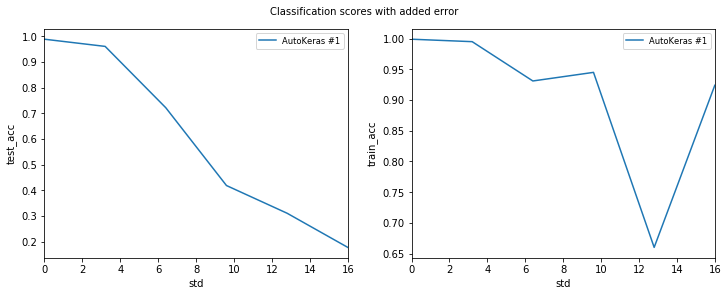

In [10]:
print_results_by_model(df,
    # ["train_labels", "test_labels"],
    ["mean", "min_val", "max_val", "train_labels", "test_labels"], 
    # err_param_name="max_angle",
    err_param_name="std",
    pipeline_name="best_pipeline"
)
visualize(df)